In [1]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 34.1 MB

In [2]:
!nvidia-smi

Wed Nov 29 16:41:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset, load_metric #a library from hugging face to handle datasets
import pandas as pd

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_ckpt = "google/pegasus-cnn_dailymail" # a model from hugging face library, built by google, size=2.28 GB >>>>> vision models
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model_nlp = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [6]:
def generate_batches_data(list_of_elements, batch_size): # because we dont want to load the complete dataset to the memory while evalutating
  for i in range(0,len(list_of_elements), batch_size):
    yield list_of_elements[i:i+batch_size]  # yield == return, diff: it returns a generator object instead of a value

In [7]:
def calculate_metric_test_ds(dataset, metric, model, tokenizer, batch_size=16, device=device, column_text="article", column_summary="highlights"):
  article_batches = list(generate_batches_data(dataset[column_text], batch_size))
  target_batches = list(generate_batches_data(dataset[column_summary], batch_size))

  for article_batch, target_batch in tqdm(
      zip(article_batches, target_batches), total=len(article_batches)):

      inputs = tokenizer(article_batch, max_length=1024, truncation=True, padding="max_length", return_tensors='pt')
      summaries = model.generate(input_ids=inputs['input_ids'].to(device),
                                 attention_mask=inputs['attention_mask'].to(device),
                                 length_penalty=0.8, num_beams=8, max_length=128) # length penalty to restrict the length of the response created

      decoded_summaries = [tokenizer.decode(s,skip_special_tokens=True, clea_up_tokenization_spaces=True) for s in summaries]
      decoded_summaries = [d.replace(""," ") for d in decoded_summaries]

      metric.add_batch(predictions=decoded_summaries, references=target_batch)

      score = metric.compute() #compute the score for generated summary, ROUGE score is used to evaluate summaries.
      return score

In [8]:
### Load data:
dataset_samsum = load_dataset("samsum") # a method in datasets lib

split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum] # split = 'train', 'test', 'validation', they are dataset objects (dicts)---> len() can be used on them andcan be indexed
print(f"split length: {split_lengths}")
print(f"features:{dataset_samsum['train'].column_names}") # dataset obj in dataset_samsum obj(dict) has method column_names
print('/nDialogue:')
print(dataset_samsum["test"][1]["dialogue"])
print(f"summary:")
print(dataset_samsum["test"][1]["summary"])
### dataset is


Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

split length: [14732, 819, 818]
features:['id', 'dialogue', 'summary']
/nDialogue:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)
summary:
Eric and Rob are going to watch a stand-up on youtube.


In [9]:
dataset_samsum

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [10]:
# evaluate pagasus on samsum:
pipe = pipeline('summarization', model= model_ckpt) # transformers lib has pipeline, it is class that abstracts complex pipeline code from huggigface lib
# more about pipeline: The pipeline() which is the most powerful object encapsulating all other pipelines.
#                      Task-specific pipelines are available for audio, computer vision, natural language processing, and multimodal tasks.
pipe_out = pipe(dataset_samsum['test'][0]['dialogue'])
print(pipe_out) # gives the summary using the base pegasus model(trained on some other data) ---> we finetune it next

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


[{'summary_text': "Amanda: Ask Larry Amanda: He called her last time we were at the park together .<n>Hannah: I'd rather you texted him .<n>Amanda: Just text him ."}]


In [11]:
model_pegasus = model_nlp

In [12]:
# evaluation
rouge_metric = load_metric('rouge')
score = calculate_metric_test_ds(dataset_samsum['test'], rouge_metric, model_pegasus, tokenizer, column_text='dialogue', column_summary="summary", batch_size=8)

<ipython-input-12-db9c140f9420>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')


  0%|          | 0/103 [00:14<?, ?it/s]


In [13]:
score

{'rouge1': AggregateScore(low=Score(precision=0.003881693165901916, recall=0.02605622928226124, fmeasure=0.006408419978860949), mid=Score(precision=0.00857170443039862, recall=0.05481199751197746, fmeasure=0.014222590444628555), high=Score(precision=0.014144468336694055, recall=0.08266182588211707, fmeasure=0.022920707079637066)),
 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.0, recall=0.0, fmeasure=0.0), high=Score(precision=0.0, recall=0.0, fmeasure=0.0)),
 'rougeL': AggregateScore(low=Score(precision=0.004199473777584471, recall=0.028255532576429043, fmeasure=0.007321113181451113), mid=Score(precision=0.00859948343654283, recall=0.05536455509416933, fmeasure=0.014310829106634063), high=Score(precision=0.01430806810666128, recall=0.08425100047807046, fmeasure=0.023140427681555515)),
 'rougeLsum': AggregateScore(low=Score(precision=0.0040361555846705355, recall=0.026609196501427988, fmeasure=0.006881477244045726), mid=Score(precisi

In [14]:
rouge_names = ['rouge1', "rouge2", 'rougeL', 'rougeLsum']
rouge_dict = dict((rn, score[rn].mid.fmeasure)for rn in rouge_names)

pd.DataFrame(rouge_dict, index=['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.014223,0.0,0.014311,0.014301


Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


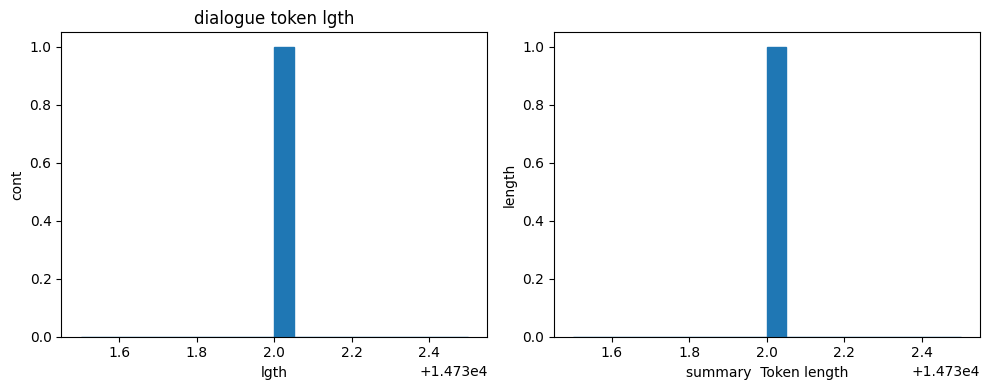

In [15]:
#histogram:

dialogue_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['dialogue']]) # dataset can be imagined like a df which has sub df train which has cols:id,dialogue,summary
summary_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['dialogue']])


fig, axes = plt.subplots(1,2, figsize=(10, 4)) # create a plot of given dim and subplots
axes[0].hist(dialogue_token_len, bins=20, color='C0', edgecolor='C0') # fill in the created plots
axes[0].set_title('dialogue token lgth')
axes[0].set_xlabel("lgth")
axes[0].set_ylabel("cont")

axes[1].hist(summary_token_len, bins=20, color='C0',edgecolor='C0')
axes[1].set_xlabel("summary  Token length")
axes[1].set_ylabel("length")
plt.tight_layout()
plt.show() #show the created--> filled plots


In [16]:
def convert_examples_to_features(example_batch): # to find embeddings of the input, so that it can be fed into the t/f
  input_encodings = tokenizer(example_batch['dialogue'], max_length= 1024, truncation=True)

  with tokenizer.as_target_tokenizer():
    target_encodings = tokenizer(example_batch['summary'], max_length=128, truncation=True)

  return {
      "input_ids": input_encodings['input_ids'],
      'attention_mask': input_encodings['attention_mask'],
      'labels': target_encodings['input_ids']
  }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)


Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [17]:
dataset_samsum_pt['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.',
 'input_ids': [12195,
  151,
  125,
  7091,
  3659,
  107,
  842,
  119,
  245,
  181,
  152,
  10508,
  151,
  7435,
  147,
  12195,
  151,
  125,
  131,
  267,
  650,
  119,
  3469,
  29344,
  1],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [12195, 7091, 3659, 111, 138, 650, 10508, 181, 3469, 107, 1]}

In [18]:
from transformers import DataCollatorForSeq2Seq
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)


In [19]:
from transformers import TrainingArguments, Trainer

# create a training arguments obj need to pass arguments to the trainer obj
trainer_args = TrainingArguments(

                                 output_dir = 'pegasus-samsum', num_train_epochs=1, warmup_steps=500,
                                 per_device_train_batch_size=1, per_device_eval_batch_size=1,
                                 weight_decay=0.01, logging_steps=10,
                                 evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
                                 gradient_accumulation_steps=16
)

ImportError: ignored

In [ ]:
trainer = Trainer(model=model_pegasus, args=trainer_args,          # from hugging face transformers lib
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt['train'],        #passing tokanized input not text
                  eval_dataset=dataset_samsum_pt['validation'])


In [ ]:
#train the model ---> just like model.fit in case of scikitlearn models
trainer.train() # prints steps, training_loss, validation_loss

In [ ]:
score = calculate_metric_test_ds(
    dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size=2, column_text='dialogue', column_summary="summary", batch_size=8
)
rouge_dict = dict((rn,score[rn].mid.fmeasure)for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f'pegasus'])